In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import yaml
import random
import os

LABELS_PATH="labels.yaml"

2023-01-17 03:54:05.556044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 03:54:06.190531: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11.3/targets/x86_64-linux/lib
2023-01-17 03:54:06.190604: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidi

In [2]:
with open(LABELS_PATH) as f:
    label_map = yaml.load(f, Loader=yaml.SafeLoader)["labels"]
reverse_label_map = {v:k for k,v in label_map.items()}
repr(reverse_label_map)

"{0: 'arresto-momentum', 1: 'descendo', 2: 'incendio', 3: 'mimblewimble', 4: 'locomotor', 5: 'tarantallegra', 6: 'gonadium'}"

In [3]:
interpreter = tf.lite.Interpreter('model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.allocate_tensors()
print(input_details)


[{'name': 'serving_default_conv2d_input:0', 'index': 0, 'shape': array([ 1, 40, 40,  1], dtype=int32), 'shape_signature': array([-1, 40, 40,  1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 0), 'quantization_parameters': {'scales': array([1.], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [4]:
image_files = []
IMAGES_DIR="images/good"
for dir,_,files in os.walk(IMAGES_DIR):
    if os.path.basename(dir) == 'crap':
        continue
    for file in files:
        image_files.append(os.path.join(dir, file))
print(len(image_files))
print(image_files[0])

761
images/good/locomotor/74799e12-1403-4409-9744-dec87227716f.png


In [5]:
def predict(image):
    img_array = np.asarray(image, dtype=np.uint8).reshape(40,40, 1)
    formatted_img_array = np.expand_dims(img_array, axis=0)

    interpreter.set_tensor(input_details[0]['index'], formatted_img_array)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    raw_pred = tf.argmax(output_data, 1).numpy()[0]

    return raw_pred


images/good/mimblewimble/5780d2e1-3fca-4192-9f6b-a5391bfa175a.png


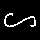

2023-01-17 03:54:07.457152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:54:07.461504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:54:07.461716: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:54:07.462323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

mimblewimble


upport.
2023-01-17 03:54:07.923811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2023-01-17 03:54:07.923974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-17 03:54:07.924006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8893 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [6]:
random_path = random.sample(image_files, k=1)[0]
print(random_path)
i = Image.open(random_path).point(lambda x: 255 if x>0 else 0)
display(i)
pred = predict(i)
print(reverse_label_map[pred])

Text(0.5, 1.0, 'Confusion Matrix')

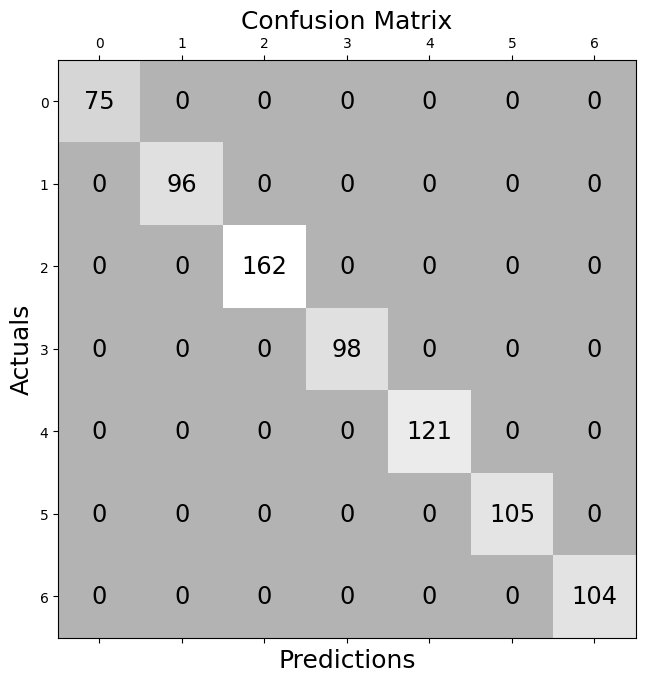

In [7]:
real_classes = []
pred_classes = []
for path in image_files:
    label = path.split(os.path.sep)[2]
    label_idx = label_map[label]
    img = Image.open(path)
    real_classes.append(label_idx)
    pred_classes.append(predict(img))

conf_matrix = tf.math.confusion_matrix(real_classes, pred_classes)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.gray, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j].numpy(), va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)